In [1]:
from __future__ import division, print_function
from os.path import join
import csv
from scipy.misc import comb

with open('../dataset_loc','r') as f:
    dataset_loc = f.read().rstrip()
imgs_dir = join(dataset_loc,'Flukes/CRC_combined constrained/')
identities_fn = join(dataset_loc,'Flukes/zooniverse-classifications/crc_ids.tsv')
img_id_map = {}
id_img_map = {}
with open(identities_fn,'r') as identities_f:
    reader = csv.DictReader(identities_f, 
                            fieldnames=['wb_context','wb_img_uuid','wb_enc_uuid','crc_id','fn'] ,
                            delimiter='\t')
    for row in reader:
        if row['fn'] in img_id_map:
            img_id_map[row['fn']].add(row['crc_id'])
        else:
            img_id_map[row['fn']] = set([row['crc_id']])
        if row['crc_id'] in id_img_map:
            id_img_map[row['crc_id']].add(row['fn'])
        else:
            id_img_map[row['crc_id']] = set([row['fn']])

In [2]:
# first let's filter out the images that are not actually there
import glob
all_images = set(map(lambda x: x.split('/')[-1], glob.glob(join(imgs_dir,'*'))))
# most images have 1 individual, but not all
len(filter(lambda x: (len(img_id_map[x]) == 1)
           and (x in all_images), img_id_map)) / len(img_id_map)

0.7059541984732824

In [3]:
double_images = set(filter(lambda x: len(img_id_map[x]) > 1, img_id_map))
missing_images = set(filter(lambda x: x not in all_images, img_id_map))
img_id_map = {x:img_id_map[x] for x in img_id_map if (x not in double_images) and (x not in missing_images)}
filt_id_img_map = {}
for indv in id_img_map:
    filtered_imgs = filter(lambda img: img in img_id_map, id_img_map[indv])
    if len(filtered_imgs) != 0:
        filt_id_img_map[indv] = filtered_imgs
len(filt_id_img_map) / len(id_img_map)

0.839517625231911

In [4]:
def make_dict_hist(dic):
    hist = {}
    for id_ in dic:
        if len(dic[id_]) in hist:
            hist[len(dic[id_])] += 1
        else:
            hist[len(dic[id_])] = 1
    return hist
def analyze_hist(id_img_hist):
    print("Whales with more than 1 image: %d" % sum([id_img_hist[length] for length in id_img_hist if length > 1]))
    print("Number of images usable: %d" % sum([id_img_hist[length]*length for length in id_img_hist if length > 1]))
    print("Number of matching pairs: %d" % sum([id_img_hist[length]*comb(length,2) for length in id_img_hist if length > 1]))
filt_id_img_hist = make_dict_hist(filt_id_img_map)
analyze_hist(filt_id_img_hist)


Whales with more than 1 image: 824
Number of images usable: 2733
Number of matching pairs: 5600


In [5]:
# let's split the train / val / test set by individual, 
# s.t. the training set will have entirely different individuals
# this way if the model is just memorizing images in the dataset it will be easy to notice

from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle, resample
from itertools import chain
import random
# there could potentially be issues here w/# indvs not corresponding to # patch pairs, but we'll ignore that for now
all_indv = filt_id_img_map.keys()
random.shuffle(all_indv)
train_indv, test_indv = train_test_split(all_indv, test_size=0.25)
train_indv, val_indv = train_test_split(train_indv, test_size=0.2)

def get_patches(indvs, indvs_patch_map):
    # now we want a dataset of ~50% matching patches (which will unfortunately be all of them)
    # and 50% non-matching patches
    # TODO (maybe) create dataset entirely of non-matching pairs from whales not in this dataset for testing
    from itertools import combinations
    matching_combinations = []
    for crcid in indvs:
        for combo in combinations(indvs_patch_map[crcid],2):
            matching_combinations.append(combo)

    non_matching_combinations = []
    max_amount = max([len(indvs_patch_map[indv]) for indv in indvs])
    for i in range(max_amount):
        indv_patches = [indvs_patch_map[crcid][i] for crcid in indvs if (
            len(indvs_patch_map[crcid]) > 1 and #awkward but we don't want to skip i = 0
            len(indvs_patch_map[crcid]) > i)]
        for combo in combinations(indv_patches,2):
            non_matching_combinations.append(combo)
    return matching_combinations, non_matching_combinations

def process_indvset(indvs, indvs_patch_map):
    # call get_patches and then mix the results together
    matching, non_matching = get_patches(indvs, indvs_patch_map)
    # resample to equal, len(matching) << len(non_matching) pretty much always
    non_matching_rs = resample(non_matching, replace=False, n_samples=len(matching))
    labels_matching = [1 for _ in matching]
    labels_non_matching = [0 for _ in non_matching_rs]
    patches_mixed, labels_mixed = shuffle(list(chain(matching, non_matching_rs)),
                                          list(chain(labels_matching, labels_non_matching)))
    return patches_mixed, labels_mixed

train_patches, train_labels = process_indvset(train_indv, filt_id_img_map)
val_patches, val_labels = process_indvset(val_indv, filt_id_img_map)
test_patches, test_labels = process_indvset(test_indv, filt_id_img_map)

0: 10306
(228, 960, 3)
1: 10306
(260, 960, 3)


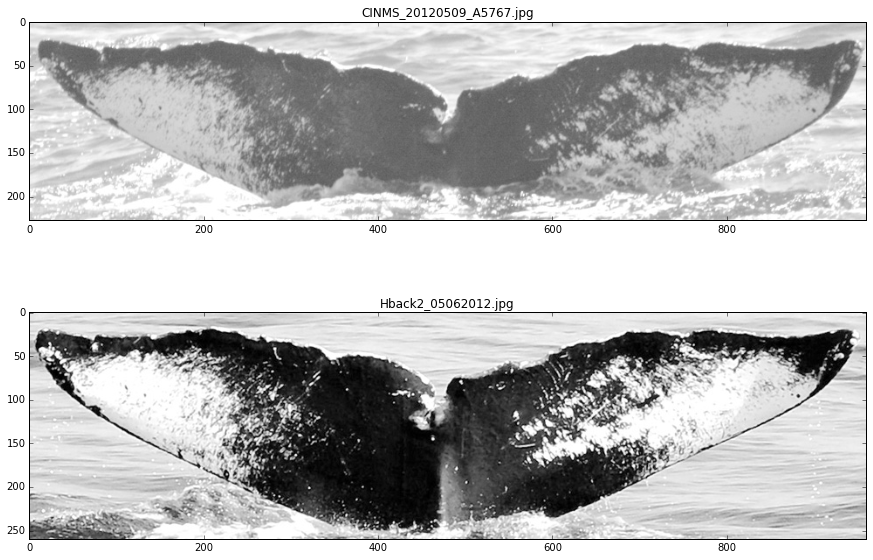

In [10]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
def view_combination(combo, imgs_dir):
    f, axarr = plt.subplots(2,figsize=(15,10))
    #combo = (normalize_patches(combo[0]), normalize_patches(combo[1]))
    for i in range(2):
        axarr[i].set_title(combo[i])
        print("%d: %s" % (i, list(img_id_map[combo[i]])[0]))
        img = cv2.cvtColor(cv2.imread(join(imgs_dir, combo[i])),cv2.COLOR_BGR2RGB)
        print(img.shape)
        axarr[i].imshow(img)
view_combination(train_patches[random.choice(filter(lambda x: train_labels[x] == 1, range(len(train_labels))))],
                 imgs_dir)

In [64]:
import cPickle as pickle
from os.path import exists
from os import mkdir
def save_dataset(dataset_name, train, val, test,
                 idmap, train_ids, val_ids, test_ids):
    working_dir = join(dataset_loc,join("Flukes/patches",dataset_name))
    if not exists(working_dir):
        mkdir(working_dir)
    else:
        print("Warning: Overwriting %s y/n" % dataset_name)
        confirm = raw_input()
        if confirm != 'y':
            return
        
    fns = ['train.pkl', 'val.pkl', 'test.pkl', 'idmap.pkl', 'train.indv', 'val.indv', 'test.indv']
    args = [train, val, test, idmap, train_ids, val_ids, test_ids]
    for fn, arg in zip(fns, args):
        with open(join(working_dir,fn),'wb') as f:
            pickle.dump(arg,f)
        
save_dataset("whole_indvsep",(train_patches, train_labels),
                                        (val_patches, val_labels),
                                        (test_patches, test_labels),
             filt_id_img_map, train_indv, val_indv, test_indv)


In [13]:
# turn into named folder format for analysis with IBEIS
# this disregards any notions of train/val/test
from shutil import rmtree, copyfile
from os.path import exists
from os import mkdir

def make_named_folders(patch_id_map, savedir, imgdir):
    working_dir = join(join(dataset_loc,"Flukes/named_images"),savedir)
    if not exists(working_dir):
        mkdir(working_dir)
    else:
        print("Warning: Going to delete %s to prevent duplicates, continue? y/n" % savedir)
        confirm = raw_input()
        if confirm != 'y':
            return
        else:
            print("Deleting %s" % working_dir)
            rmtree(working_dir)
            mkdir(working_dir)
            
    for indv_id in patch_id_map:
        for imgname in patch_id_map[indv_id]:
            #for pname in patch_names:
            indv_folder = join(working_dir,'%s' % (indv_id,))
            if not exists(indv_folder):
                mkdir(indv_folder)
            #cv2.imwrite(join(indv_patch_folder,'%s.jpg' % imgnum),patches[pname]) 
            copyfile(join(imgdir, imgname), join(indv_folder, imgname))
make_named_folders(filt_id_img_map, 'CRC_constrained', imgs_dir)